# Histopathologic Cancer Detection

** Problem Statement **

With the increases in cases of cancer, early detection and treatment is of vital importance as it relates to reduction in mortality rate among certain groups in the population. This project focuses on identifying metastatic tissue in histopathologic scans of lymph node sections.

** Audience **

The audience that would benefit from this study are those involved in the detection of cancer cells, researchers and manufacturers of biomedical equipment. This model can easily provide researchers with the tools to take the guesswork out of cell classification which will reduce time research cycles. The algorithm can be productionized in imagining biomedical devices used for cell classification. 

In [11]:
#import the necessary modules
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau

from skimage import io

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2035503251768866318
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3163724185
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7273652203946123808
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
# Load labels
df_train = pd.read_csv('data/train_labels.csv')
df_train.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


## Exploratory Data Analysis

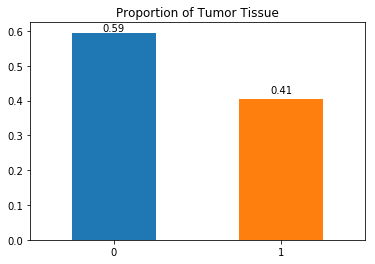

In [5]:
df_train['label'].value_counts(normalize=True).plot.bar(rot=0)

plt.title('Proportion of Tumor Tissue')

#Add labels
x = list(round(df_train['label'].value_counts(normalize=True), 2).index)
y = round(df_train['label'].value_counts(normalize=True), 2)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

In [9]:
#Load train and test set
train_files = glob('data/train/*.tif')
test_files = glob('data/test/*.tif')

In [7]:
#Identify the count for train and test set
print("Train file count :", len(train_files))
print("Test file count :", len(test_files))

Train file count : 220025
Test file count : 57458


## Data Description

Data was obtained from the Kaggle competition, Histopathologic Cancer Detection. The dataset can be obtained here, kaggle.com/c/histopathologic-cancer-detection 

The folder contains 277,483 images (7.41 GB) of small pathology images of which 220,025 are for training and 57,458 for testing. Each image has a resolution of 96 x 96 px, however only the center 32x32 px region is used for this binary classification as having at least one pixel of tumor tissue. 

Each image varies in cell density, shape, size, and staining. 

Along with the images the folder contains a csv file that contains the labels for the training data. Simple visualization reveals that 90,210 (41%) of the training images contain tumor cells in the center 32x32 px region. 


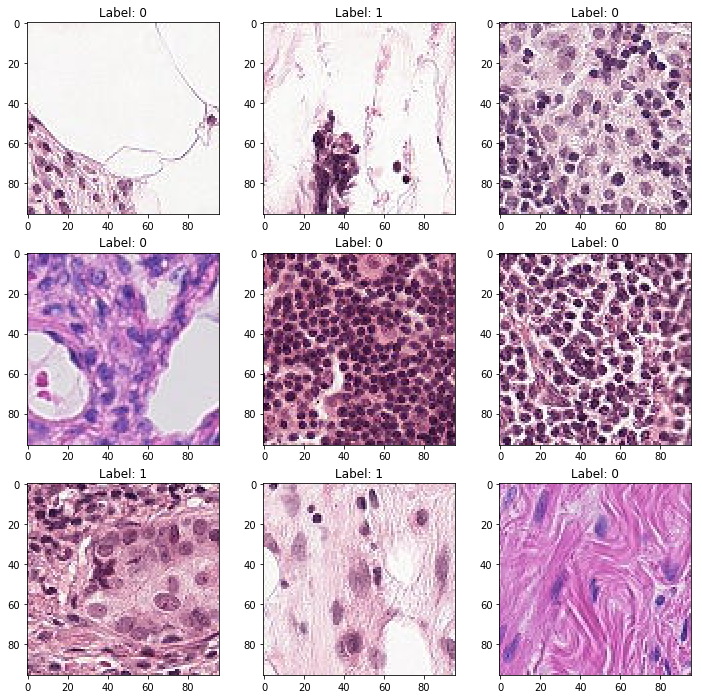

In [31]:
# View a 3 x 3 grid of images
plt.figure(figsize=(12,12))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(io.imread('data/train/{}.tif'.format(df_train.id[i])))
    plt.title('Label: {}'.format(df_train.label[i]))

(96, 96, 3)


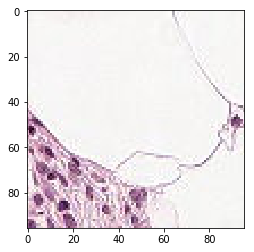

In [9]:
# View a sample image
example = io.imread('data/train/{}.tif'.format(df_train.id[0]))
print(example.shape)
plt.imshow(example)

In [10]:
#Center Cropping
#def ctr_img_crop(im):
    #img = Image.open(im)
    #w, h = img.size

    #return img.crop((w//2 - n_w//2, h//2 - n_h//2, w//2 + n_w//2, h//2 + n_h//2))

#New image dimesions
#n_w = 64
#n_h = 64

#Center crop train set
#for i in tqdm(range(len(train_files))):
    #crop_img = ctr_img_crop('data/train/{}.tif'.format(df_train.id[i]))
    #crop_img.save('data/train_crop/{}.tif'.format(df_train.id[i]))

#Center crop test set
#for i in tqdm(range(len(test_files))):
    #crop_img = ctr_img_crop('data/test/{}.tif'.format(df_test.id[i]))
    #crop_img.save('data/test_crop/{}.tif'.format(df_test.id[i]))
    
#View 3 x 3 cropped images
#plt.figure(figsize=(10,10))
#for i in range(0, 9):
    #plt.subplot(330 + 1 + i)
    #plt.imshow(io.imread('data/train_crop/{}.tif'.format(df_train.id[i])))

## Data Preprocessing (CPU)

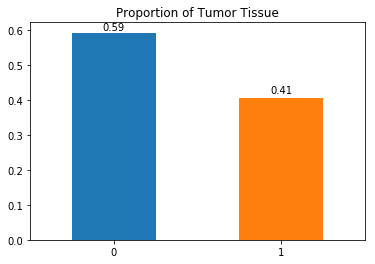

In [11]:
df_sub = df_train.sample(100000, random_state= 35)

df_sub['label'].value_counts(normalize=True).plot.bar(rot=0)

plt.title('Proportion of Tumor Tissue')

#Add labels
x = list(round(df_sub['label'].value_counts(normalize=True), 2).index)
y = round(df_sub['label'].value_counts(normalize=True), 2)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

## Build the Model

In [12]:
# Initialising the CNN
model = Sequential()

# First set of convolution layers
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))

# Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))

# Second set of convolutional layer
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

In [13]:
# Add Dropout to prevent over fitting
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Full connection
model.add(Dense(units = 128, activation = 'relu'))

# Add Dropout to prevent over fitting
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = 'sigmoid', name = 'pred'))

In [14]:
# View summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 42, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0         
__________

In [15]:
# Image augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   channel_shift_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   validation_split = 0.25)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
#Split train data
train_set = train_datagen.flow_from_dataframe(dataframe = df_train,
                                              directory = 'data/train',
                                              x_col = 'id',
                                              y_col = 'label',
                                              has_ext = False,
                                              target_size = (96, 96),
                                              batch_size = 64,
                                              class_mode = 'binary',
                                              subset = 'training')

eval_set = train_datagen.flow_from_dataframe(dataframe = df_train,
                                            directory = 'data/train',
                                            x_col = 'id',
                                            y_col = 'label',
                                            has_ext = False,
                                            target_size = (96, 96),
                                            batch_size = 64,
                                            class_mode = 'binary',
                                            subset = 'validation',
                                            shuffle = False)

Found 165019 images belonging to 2 classes.
Found 55006 images belonging to 2 classes.


In [17]:
#Calculate steps for model training
train_steps = train_set.n//train_set.batch_size
eval_steps = eval_set.n//eval_set.batch_size

print(train_steps)
print(eval_steps)

2578
859


In [18]:
filepath = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

#Callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2, verbose = 1, restore_best_weights=True)

reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, verbose = 1, cooldown = 1)

csvlogger = CSVLogger(filename = "training_csv.log", separator = ",", append = False)

In [19]:
# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [20]:
# Model Training
hist = model.fit_generator(train_set,
                    steps_per_epoch = train_steps,
                    epochs = 30,
                    validation_data = eval_set,
                    validation_steps = eval_steps,
                    callbacks = [checkpoint, reduce, csvlogger])

Epoch 1/25
2578/2578 [==============================] - 2375s 921ms/step - loss: 0.4757 - acc: 0.7764 - val_loss: 0.3815 - val_acc: 0.8387

Epoch 00001: val_loss improved from inf to 0.38154, saving model to ./base.model
Epoch 2/25
2578/2578 [==============================] - 2208s 857ms/step - loss: 0.3869 - acc: 0.8348 - val_loss: 0.3421 - val_acc: 0.8528

Epoch 00002: val_loss improved from 0.38154 to 0.34207, saving model to ./base.model
Epoch 3/25
2578/2578 [==============================] - 2206s 856ms/step - loss: 0.3527 - acc: 0.8510 - val_loss: 0.3112 - val_acc: 0.8659

Epoch 00003: val_loss improved from 0.34207 to 0.31117, saving model to ./base.model
Epoch 4/25
2578/2578 [==============================] - 2197s 852ms/step - loss: 0.3314 - acc: 0.8611 - val_loss: 0.2940 - val_acc: 0.8778

Epoch 00004: val_loss improved from 0.31117 to 0.29400, saving model to ./base.model
Epoch 5/25
2578/2578 [==============================] - 2200s 853ms/step - loss: 0.3125 - acc: 0.8718 - 

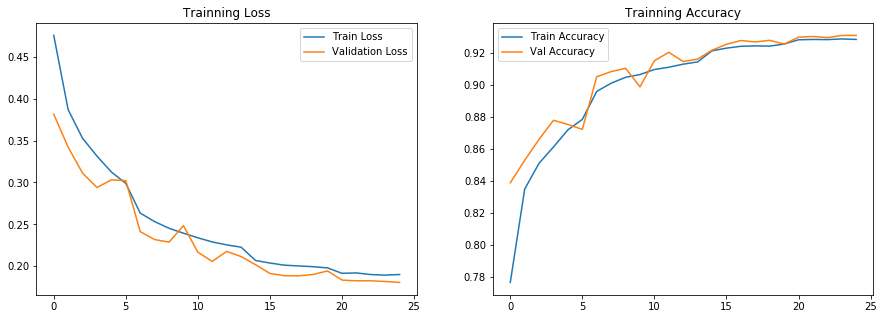

In [23]:
plt.figure(figsize=(15, 5))
#Plot Trainning loss
plt.subplot(1, 2, 1)
plt.plot(hist.epoch, hist.history['loss'], label = 'Train Loss')
plt.plot(hist.epoch, hist.history['val_loss'], label = 'Validation Loss')
plt.title('Trainning Loss')
plt.legend()

#Plot Trainning Accuracy
plt.subplot(1, 2, 2)
plt.plot(hist.epoch, hist.history['acc'], label = 'Train Accuracy')
plt.plot(hist.epoch, hist.history['val_acc'], label = 'Val Accuracy')
plt.title('Trainning Accuracy')
plt.legend()

In [3]:
df_test = pd.read_csv('data/sample_submission.csv')
df_test.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [15]:
from tqdm import tqdm
from keras.preprocessing import image

predictions = []

for i in tqdm(range(len(test_files))):
    img = image.load_img('data/test/{}.tif'.format(df_test.id[i]), target_size = (96, 96))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    result = model.predict(img)
    predictions.append(result[0][0])    

100%|███████████████████████████████████████████████████████████████████████████| 57458/57458 [09:22<00:00, 102.11it/s]
